リードの中で variant を定義して、ユニットをそれらの variant 列で表現する。そして、その k-variant 列を使って overlap filtering を試みる。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.templates.default = 'plotly_white'
import logging
import logzero
logzero.loglevel(logging.DEBUG)

In [2]:
dir_fname = 'work'
import os
os.chdir(dir_fname)

In [3]:
import numpy as np
from copy import copy
import pandas as pd
from BITS.clustering.seq import ClusteringSeq
from BITS.seq.align import EdlibRunner
from BITS.seq.consed import ConsedRunner
from BITS.util.io import save_pickle, load_pickle
from BITS.util.io import load_pickle, save_pickle
import numpy as np
import pandas as pd
from BITS.plot.plotly import make_hist, make_scatter, make_layout, show_plot
from BITS.clustering.seq import ClusteringSeq
import consed
from BITS.seq.align import EdlibRunner
from collections import Counter, defaultdict
from logzero import logger
from dataclasses import dataclass
from typing import List, Tuple
import random
from copy import copy
from collections import Counter
from dataclasses import dataclass
from logzero import logger
import numpy as np
from vca.types import TRUnit
from BITS.clustering.seq import ClusteringSeq
from BITS.seq.align import EdlibRunner
from BITS.util.io import load_pickle, save_pickle
from BITS.util.proc import NoDaemonPool
from BITS.seq.utils import revcomp

In [4]:
def read_to_forward_units(read):
    """Return all units contained in <read> so that starnd of every unit is same as the forward master unit."""
    return [read.seq[unit.start:unit.end] if unit.id == 0 else revcomp(read.seq[unit.start:unit.end])
            for unit in read.units]

In [5]:
sync_reads = load_pickle("centromere_reads_incl_low_cover_rate_all_sync.pkl")

In [43]:
len(sync_reads)

1905

In [6]:
sync_units = []
for read in sync_reads:
    sync_units += read_to_forward_units(read)

In [9]:
len(sync_units)

46538

In [7]:
centromere_phreds = load_pickle("centromere_phreds_incl_low_cover_rate_all_sync.pkl")

In [8]:
sync_quals = []
for read in sync_reads:
    sync_quals += [centromere_phreds[read.name][unit.start:unit.end] if unit.id == 0
                   else np.flip(centromere_phreds[read.name][unit.start:unit.end])
                   for unit in read.units]

-> この数ではクラスタリングも厳しい。

In [7]:
db_prefix = "DMEL_CSS"
db_fname = f"{db_prefix}.db"
las_fname = f"TAN.{db_prefix}.las"
from vca import ReadViewer
v = ReadViewer(db_fname, las_fname)

In [6]:
sync_reads_by_id = {read.id: read for read in sync_reads}

In [7]:
logzero.loglevel(logging.INFO)
v.show(read=sync_reads_by_id[73])
logzero.loglevel(logging.DEBUG)

[I 190920 22:02:55 log:17] Starting distance matrix calculation 
[I 190920 22:02:56 log:19] Finished distance matrix calculation


In [78]:
!(cat master_unit)

caaaaatgttgatatttacaaacgaaattttcgttataacttggctaaaaatggtcacatagatgtaagaataactgttttgagcagctaattaccagtgctaacgatccctattactttttgaaggatttagggaaattaatttttggatcaattttcgcattttttgtaaggaggggggtcatcaaaatttgcaaaatatggccaaaaaatttaatttccatttttgaacacagtttgattggaaattttattacgagctcagtgaggtatgacattccatattcagacaattattttttatgttgtggcaaaataaatgattatttgatgaccgaaatttggaaaaacagactctg


In [7]:
master_unit = "caaaaatgttgatatttacaaacgaaattttcgttataacttggctaaaaatggtcacatagatgtaagaataactgttttgagcagctaattaccagtgctaacgatccctattactttttgaaggatttagggaaattaatttttggatcaattttcgcattttttgtaaggaggggggtcatcaaaatttgcaaaatatggccaaaaaatttaatttccatttttgaacacagtttgattggaaattttattacgagctcagtgaggtatgacattccatattcagacaattattttttatgttgtggcaaaataaatgattatttgatgaccgaaatttggaaaaacagactctg"

## Compute variant counts globally

forward master unit の上で global variant set を定義する。

In [8]:
# Variants and sequencing errors

class PairwiseAlignment:
    def __init__(self, a_seq, b_seq):
        er = EdlibRunner("global", revcomp=False, cyclic=False)
        self.fcigar = er.align(b_seq.lower(), a_seq.lower()).cigar.flatten().string   # NOTE: b vs a; be careful!
        self.source, self.target = '', ''
        s_pos, t_pos = 0, 0
        for c in self.fcigar:
            if c == '=' or c == 'X':
                self.source += a_seq[s_pos]
                self.target += b_seq[t_pos]
                s_pos += 1
                t_pos += 1
            elif c == 'I':
                self.source += '-'
                self.target += b_seq[t_pos]
                t_pos += 1
            else:
                self.source += a_seq[s_pos]
                self.target += '-'
                s_pos += 1
        
    def show(self, by_cigar=False):
        if by_cigar:   # standard alignment like BLAST
            print(self.source)
            print(self.fcigar)
            print(self.target)
        else:
            print(''.join([' ' if c == '=' else self.source[i] for i, c in enumerate(self.fcigar)]))
            print(''.join([self.source[i] if c == '=' else ' ' for i, c in enumerate(self.fcigar)]))
            print(''.join([' ' if c == '=' else self.target[i] for i, c in enumerate(self.fcigar)]))

def count_variants(cluster_cons_unit, cluster_units):
    """Given a set of unit sequences <units> in a cluster, calculate the composition of
    nucleotides including '-' (= distribution of each )
    for each position on <cluster_cons_unit> as a seed.
    from which <units> are generated, compute the variations (= nucleotides inconsistent between
    <units> and <cluster_cons_unit> and their relative frequency).
    Since a cluster should be homogeneous (i.e., mono-source), the relative frequencies are
    expected to be not much larger than sequencing error.
    """
    assert cluster_cons_unit != "", "Empty strings are not allowed"
    # TODO: how to decide "same variant?" especially for multiple variations on same position (but slightly different among units)?
    variants = Counter()
    for unit in cluster_units:
        assert unit != "", "Empty strings are not allowed"
        alignment = PairwiseAlignment(cluster_cons_unit, unit)   # alignment.fcigar(cluster_cons_unit) = unit
        #logger.info(alignment.fcigar)
        tpos = 0
        var_index = 0   # positive values for continuous insertions
        for i, c in enumerate(alignment.fcigar):
            if c == '=':
                var_index = 0
            elif c == 'I':
                var_index += 1
            if c != '=':
                variants[(tpos, var_index, c, alignment.target[i])] += 1   # TODO: multiple D on the same pos are aggregated
            if c != 'I':
                tpos += 1
        assert tpos == len(cluster_cons_unit)
    return sorted(variants.items())

def list_variations(template_unit, cluster_cons_unit):
    """Single-vs-single version of count_variants().
    That is, list up the differences between the (imaginary) template unit and the consensus unit
    of a cluster (which should be a real instance).
    The return value is [(position_on_template_unit, variant_type, base_on_cluster_cons_unit)].
    """
    assert template_unit != "" and cluster_cons_unit != "", "Empty strings are not allowed"
    return set(dict(count_variants(template_unit, [cluster_cons_unit])).keys())

In [29]:
len(sync_units)

46539

In [52]:
global_variants = count_variants(master_unit, sync_units)

In [60]:
len(global_variants)

2916

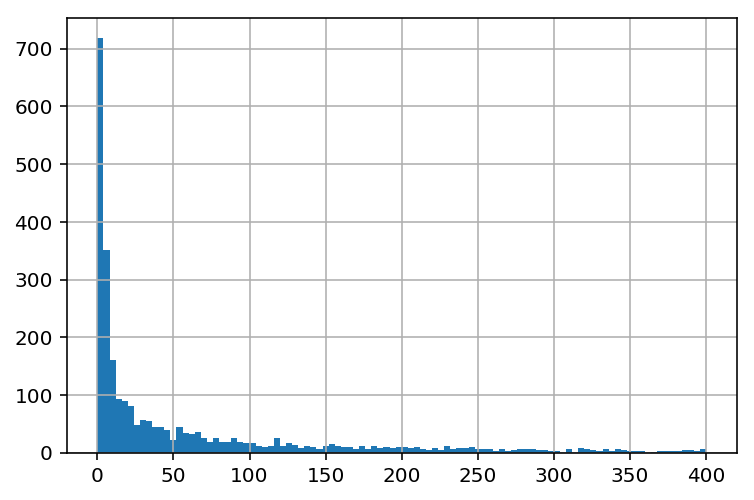

In [53]:
pd.Series([x[1] for x in global_variants]).hist(bins=100, range=(0, 400))

In [70]:
min_frac = 0.01   # in all units
global_variants_filtered = list(filter(lambda x: x[1] >= len(sync_units) * min_frac, global_variants))

In [71]:
len(global_variants_filtered)

241

In [72]:
global_variants_filtered[:100]

[((1, 0, 'X', 'c'), 5886),
 ((4, 0, 'X', 'g'), 2535),
 ((4, 1, 'I', 'g'), 1731),
 ((5, 0, 'D', '-'), 8605),
 ((5, 0, 'X', 'g'), 2110),
 ((6, 0, 'X', 'a'), 2155),
 ((7, 0, 'D', '-'), 2127),
 ((7, 0, 'X', 'a'), 4810),
 ((8, 0, 'X', 'a'), 4711),
 ((9, 0, 'D', '-'), 2485),
 ((9, 0, 'X', 'a'), 4596),
 ((9, 0, 'X', 'g'), 1366),
 ((10, 0, 'D', '-'), 677),
 ((12, 0, 'X', 'a'), 609),
 ((15, 0, 'X', 'g'), 739),
 ((16, 0, 'D', '-'), 840),
 ((21, 0, 'D', '-'), 517),
 ((21, 0, 'X', 'c'), 668),
 ((22, 0, 'X', 't'), 610),
 ((23, 0, 'D', '-'), 793),
 ((23, 0, 'X', 'a'), 1890),
 ((23, 0, 'X', 'c'), 5843),
 ((26, 0, 'D', '-'), 645),
 ((30, 0, 'D', '-'), 674),
 ((32, 0, 'X', 't'), 969),
 ((34, 0, 'X', 'c'), 8442),
 ((36, 0, 'X', 'a'), 488),
 ((38, 0, 'X', 'g'), 744),
 ((40, 0, 'X', 'a'), 552),
 ((41, 0, 'X', 'c'), 696),
 ((43, 0, 'X', 'c'), 1195),
 ((44, 0, 'X', 'a'), 1556),
 ((44, 0, 'X', 't'), 3622),
 ((47, 0, 'X', 'g'), 1037),
 ((48, 0, 'X', 'c'), 1049),
 ((50, 0, 'D', '-'), 931),
 ((51, 1, 'I', 'a'),

In [73]:
global_vars = set(dict(global_variants_filtered).keys())

In [37]:
global_vars

{(1, 0, 'X', 'c'),
 (4, 0, 'X', 'g'),
 (4, 1, 'I', 'g'),
 (5, 0, 'D', '-'),
 (5, 0, 'X', 'g'),
 (6, 0, 'X', 'a'),
 (7, 0, 'D', '-'),
 (7, 0, 'X', 'a'),
 (8, 0, 'X', 'a'),
 (9, 0, 'D', '-'),
 (9, 0, 'X', 'a'),
 (9, 0, 'X', 'g'),
 (10, 0, 'D', '-'),
 (12, 0, 'X', 'a'),
 (15, 0, 'X', 'g'),
 (16, 0, 'D', '-'),
 (21, 0, 'D', '-'),
 (21, 0, 'X', 'c'),
 (22, 0, 'X', 't'),
 (23, 0, 'D', '-'),
 (23, 0, 'X', 'a'),
 (23, 0, 'X', 'c'),
 (26, 0, 'D', '-'),
 (30, 0, 'D', '-'),
 (31, 0, 'X', 't'),
 (32, 0, 'X', 't'),
 (34, 0, 'X', 'c'),
 (36, 0, 'X', 'a'),
 (38, 0, 'X', 'g'),
 (40, 0, 'X', 'a'),
 (41, 0, 'X', 'c'),
 (43, 0, 'X', 'c'),
 (44, 0, 'X', 'a'),
 (44, 0, 'X', 't'),
 (47, 0, 'X', 'g'),
 (48, 0, 'X', 'c'),
 (50, 0, 'D', '-'),
 (51, 1, 'I', 'a'),
 (52, 0, 'X', 'a'),
 (52, 0, 'X', 't'),
 (53, 0, 'D', '-'),
 (55, 0, 'X', 'g'),
 (60, 0, 'X', 'c'),
 (65, 0, 'X', 'a'),
 (67, 0, 'X', 'c'),
 (68, 0, 'X', 'c'),
 (70, 0, 'D', '-'),
 (71, 0, 'X', 'c'),
 (72, 0, 'D', '-'),
 (73, 0, 'D', '-'),
 (73, 0, 'X'

In [63]:
sync_unit_global_varvecs = [list_variations(master_unit, unit) & global_vars for unit in sync_units]

In [64]:
sync_unit_global_varvecs[:10]

[{(21, 0, 'X', 'c'),
  (23, 0, 'D', '-'),
  (52, 0, 'X', 't'),
  (68, 0, 'X', 'c'),
  (81, 0, 'X', 'a'),
  (109, 0, 'X', 't'),
  (112, 0, 'X', 'g'),
  (148, 0, 'X', 'a'),
  (153, 0, 'X', 'c'),
  (185, 0, 'X', 'g'),
  (206, 0, 'X', 'c'),
  (265, 0, 'X', 'a'),
  (325, 0, 'D', '-'),
  (329, 0, 'D', '-'),
  (330, 0, 'D', '-'),
  (334, 0, 'D', '-'),
  (335, 0, 'D', '-'),
  (336, 0, 'D', '-'),
  (339, 0, 'D', '-')},
 {(9, 0, 'X', 'a'),
  (21, 0, 'D', '-'),
  (67, 0, 'X', 'c'),
  (73, 0, 'X', 't'),
  (88, 0, 'X', 'a'),
  (134, 0, 'D', '-'),
  (195, 0, 'X', 'c')},
 {(47, 0, 'X', 'g'),
  (48, 0, 'X', 'c'),
  (67, 0, 'X', 'c'),
  (73, 0, 'X', 't'),
  (88, 0, 'X', 'a'),
  (134, 0, 'D', '-'),
  (150, 0, 'X', 'c'),
  (180, 0, 'D', '-'),
  (195, 0, 'X', 'c'),
  (325, 0, 'D', '-')},
 {(5, 0, 'D', '-'),
  (21, 0, 'X', 'c'),
  (23, 0, 'D', '-'),
  (52, 0, 'X', 't'),
  (68, 0, 'X', 'c'),
  (81, 0, 'X', 'a'),
  (109, 0, 'X', 't'),
  (148, 0, 'X', 'a'),
  (153, 0, 'X', 'c'),
  (195, 0, 'X', 'c'),
  (212, 

## Parse a read to k-varvecs

revcomp に気をつけて k-varvec signature を構築する。

`List[(k-varvec, read_id, start_pos)]`

### Not used code

In [153]:
k = 5

@dataclass
class VarVec:
    variants: tuple   # sorted variants
    strand: int   # 0/1; against the mater unit
        
    def __post_init__(self):
        self.variants = tuple(sorted(self.variants))
    
    def __eq__(self, other_varvec):
        return self.strand == other_varvec.strand and self.variants == other_varvec.variants
    
    def __hash__(self):
        return hash((self.variants, self.strand))

@dataclass
class KVarVec:
    read_id: int
    start_pos: int   # index of start UNIT
    strand: int   # 0/1; from which strand of the READ self is generated
    varvecs: Tuple[VarVec]   # of length k

    def __post_init__(self):
        self.varvecs = tuple(self.varvecs)

    def __eq__(self, other_k_varvec):
        return self.varvecs == other_k_varvec.varvecs

    @property
    def varvecs_revcomp(self):
        return tuple([VarVec(varvec.variants, 1 - varvec.strand) for varvec in reversed(self.varvecs)])

In [ ]:
def read_to_k_varvecs(read, k=5):
    sync_units = [(read.seq[unit.start:unit.end] if unit.id == 0 else revcomp(read.seq[unit.start:unit.end]),
                   unit.id)
                  for unit in read.units]   # [(forward_sync_unit, strand)]
    sync_global_varvecs = [VarVec(list_variations(master_unit, unit) & global_vars, strand) for unit, strand in sync_units]
    
    k_varvecs = []
    for i in range(len(sync_global_varvecs) - k + 1):
        # For each k-varvec, add both forward k-varvec and revcomp k-varvec
        k_varvec = KVarVec(read.id, i, 0, [sync_global_varvecs[j] for j in range(i, i + k)])
        k_varvec_rc = KVarVec(read.id, i + k - 1, 1, k_varvec.varvecs_revcomp)
        k_varvecs += [k_varvec, k_varvec_rc]
        
    return k_varvecs

In [157]:
k_varvec_counts = Counter([k_varvec.varvecs for k_varvec in all_k_varvecs])

### Below are used code

In [74]:
def read_to_k_varvecs(read, k=5):
    sync_units = [(read.seq[unit.start:unit.end] if unit.id == 0 else revcomp(read.seq[unit.start:unit.end]),
                   unit.id)
                  for unit in read.units]   # [(forward_sync_unit, strand)]
    sync_global_varvecs = [(tuple(sorted(list_variations(master_unit, unit) & global_vars)), strand) for unit, strand in sync_units]
    
    k_varvecs = []
    for i in range(len(sync_global_varvecs) - k + 1):
        # For each k-varvec, add both forward k-varvec and revcomp k-varvec
        k_varvec = [sync_global_varvecs[j] for j in range(i, i + k)]
        k_varvec_rc = [(varvec, 1 - strand) for varvec, strand in reversed(k_varvec)]
        k_varvecs += [(tuple(k_varvec), read.id, i, 0), (tuple(k_varvec_rc), read.id, i + k - 1, 1)]   # (k_varvec, read_id, start_pos, strand)
        
    return k_varvecs

In [75]:
all_k_varvecs = []
for read in sync_reads:
    all_k_varvecs += read_to_k_varvecs(read, k=2)

In [67]:
len(all_k_varvecs)

89748

In [76]:
k_varvec_counts = Counter([k_varvec for k_varvec, read_id, start_pos, strand in all_k_varvecs])

In [77]:
show_plot([make_hist(list(k_varvec_counts.values()), bin_size=1, start=2)])

2回しか出現しないのは流石に厳しすぎるので、もう少し緩い signature を探す

In [78]:
# min_count と max_count の間のカウント数を持つ varvec だけを使う
min_count = 2
max_count = 10
match_k_varvecs = set()
for k_varvec, count in filter(lambda x: min_count <= x[1] and x[1] <= max_count, k_varvec_counts.items()):
    match_k_varvecs.add(k_varvec)

In [79]:
len(match_k_varvecs) / 2

3894.0

In [80]:
k_varvec_to_reads = defaultdict(list)
for k_varvec, read_id, start_pos, strand in all_k_varvecs:
    if k_varvec in match_k_varvecs:
        k_varvec_to_reads[k_varvec].append((read_id, start_pos, strand))

In [81]:
overlaps = defaultdict(list)
for k_varvec, reads in k_varvec_to_reads.items():
    for i in range(len(reads)):
        read_id_i, start_pos_i, strand_i = reads[i]
        for j in range(i + 1, len(reads)):
            read_id_j, start_pos_j, strand_j = reads[j]
            if read_id_i == read_id_j:   #  remove self-vs-self matching (probably due to inversion copy)
                continue
            if read_id_i < read_id_j:
                overlaps[(read_id_i, read_id_j)].append((strand_i, start_pos_i, strand_j, start_pos_j))
            else:
                overlaps[(read_id_j, read_id_i)].append((strand_j, start_pos_j, strand_i, start_pos_i))

In [82]:
sorted(overlaps.keys())

[(73, 7556),
 (73, 90327),
 (73, 99318),
 (73, 198167),
 (73, 211431),
 (73, 381787),
 (73, 401347),
 (73, 419216),
 (236, 369),
 (236, 126109),
 (236, 191931),
 (236, 205021),
 (236, 241631),
 (236, 270975),
 (236, 380798),
 (236, 436104),
 (300, 54493),
 (300, 188006),
 (300, 246507),
 (300, 260016),
 (300, 324865),
 (300, 335080),
 (300, 433877),
 (369, 75008),
 (369, 141704),
 (369, 191931),
 (369, 194397),
 (369, 205021),
 (369, 241631),
 (369, 261770),
 (369, 380798),
 (546, 8877),
 (546, 29126),
 (546, 31379),
 (546, 31458),
 (546, 84451),
 (546, 147506),
 (546, 174254),
 (546, 240025),
 (546, 272397),
 (546, 273709),
 (546, 366181),
 (546, 407948),
 (559, 95028),
 (559, 129550),
 (559, 132531),
 (559, 262499),
 (559, 299496),
 (559, 328341),
 (559, 336063),
 (741, 5208),
 (741, 133575),
 (741, 189418),
 (741, 199109),
 (741, 311507),
 (741, 319453),
 (741, 347980),
 (741, 369456),
 (741, 439929),
 (765, 248365),
 (765, 318737),
 (765, 354688),
 (765, 356798),
 (797, 303176),
 (

In [83]:
len(set([xx for x in sorted(overlaps.keys()) for xx in x]))

1354

In [51]:
len(sync_reads)

1905

1905 reads のうち 1354 reads が何らかの overlap を持っている。

通常の overlap の形式に変換する

In [90]:
# read A is always forward in overlaps
filtered_overlaps = []
for (read_a, read_b), positions in sorted(overlaps.items()):
    filtered_overlaps.append((read_a, read_b, sorted(list(filter(lambda x: x[0] == 0, positions)))))

In [91]:
filtered_overlaps

[(73, 7556, [(0, 10, 1, 30), (0, 10, 1, 35), (0, 11, 1, 34)]),
 (73,
  90327,
  [(0, 10, 0, 18),
   (0, 10, 0, 28),
   (0, 11, 0, 19),
   (0, 11, 0, 29),
   (0, 12, 0, 30)]),
 (73, 99318, [(0, 30, 0, 14), (0, 31, 0, 15)]),
 (73,
  198167,
  [(0, 3, 0, 9),
   (0, 3, 0, 22),
   (0, 3, 0, 25),
   (0, 6, 0, 12),
   (0, 7, 0, 1),
   (0, 7, 0, 13),
   (0, 10, 0, 16),
   (0, 11, 0, 4),
   (0, 11, 0, 17),
   (0, 12, 0, 5),
   (0, 12, 0, 18),
   (0, 15, 0, 21),
   (0, 16, 0, 9),
   (0, 16, 0, 22),
   (0, 16, 0, 25),
   (0, 17, 0, 23),
   (0, 21, 0, 27)]),
 (73, 211431, [(0, 10, 1, 6), (0, 10, 1, 16)]),
 (73, 381787, [(0, 30, 1, 30), (0, 31, 1, 29), (0, 32, 1, 28)]),
 (73, 401347, [(0, 30, 0, 9)]),
 (73, 419216, [(0, 6, 0, 3)]),
 (236, 369, [(0, 8, 1, 9), (0, 8, 1, 16)]),
 (236, 126109, [(0, 9, 0, 27)]),
 (236, 191931, [(0, 8, 1, 4)]),
 (236, 205021, [(0, 8, 1, 7)]),
 (236, 241631, [(0, 6, 1, 8), (0, 8, 1, 5)]),
 (236, 270975, [(0, 9, 0, 26)]),
 (236, 380798, [(0, 9, 0, 0)]),
 (236, 436104, [(0,

- 各 exact match がそれぞれ strand consistent かどうかをチェックする

In [93]:
for a, b, poss in filtered_overlaps:
    map_strands = [pos[2] for pos in poss]
    if len(set(map_strands)) != 1:
        logger.warn("INCONSISTENT {a} vs {b}")

-> すべて consistent!

In [94]:
# 各リードの overlap の数
n_ovlps = Counter()
for a, b, poss in filtered_overlaps:
    n_ovlps[a] += 1
    n_ovlps[b] += 1

In [95]:
n_ovlps_for_each_read = [n_ovlps[read.id] for read in sync_reads]

In [96]:
show_plot([make_hist(n_ovlps_for_each_read)])

~500 reads を無駄にはしているが、悪くない分布では

In [100]:
import igraph as ig
graph = ig.Graph.DictList(edges=(dict(source=a, target=b) for a, b, poss in filtered_overlaps),
                             vertices=None,
                             directed=False)

In [106]:
cc = [(g, g.vcount()) for g in graph.clusters(mode="weak").subgraphs() if g.vcount() >= 10]

In [107]:
cc

[(<igraph.Graph at 0x2b087827c318>, 694),
 (<igraph.Graph at 0x2b087827c138>, 100),
 (<igraph.Graph at 0x2b0877e33e58>, 89),
 (<igraph.Graph at 0x2b0877e33b88>, 16),
 (<igraph.Graph at 0x2b0877e339a8>, 84),
 (<igraph.Graph at 0x2b0877e338b8>, 22),
 (<igraph.Graph at 0x2b0877e337c8>, 23),
 (<igraph.Graph at 0x2b0877e33318>, 107),
 (<igraph.Graph at 0x2b0877e33138>, 19),
 (<igraph.Graph at 0x2b0877e33d68>, 13),
 (<igraph.Graph at 0x2b0877e33048>, 12),
 (<igraph.Graph at 0x2b08779027c8>, 12),
 (<igraph.Graph at 0x2b08779026d8>, 19)]

In [109]:
cc[0][0]

In [70]:
from BITS.plot.plotly import make_line, make_hist, make_scatter, make_layout, show_plot
import plotly.graph_objs as go

def draw_graph(sg):
    E = [e.tuple for e in sg.es]
    N = sg.vcount()
    pos = sg.layout('kk')

    edge_trace = go.Scatter(x=[i for l in [(pos[s][0], pos[t][0], None) for s, t in E] for i in l],
                            y=[i for l in [(pos[s][1], pos[t][1], None) for s, t in E] for i in l],
                            line=dict(width=0.5, color='black'),
                            mode='lines')

    shapes = [make_line(pos[s][0] + (pos[t][0] - pos[s][0]) * 0.7,
                        pos[s][1] + (pos[t][1] - pos[s][1]) * 0.7,
                        pos[t][0],
                        pos[t][1],
                        "black",
                        4,
                        "below")
              for s, t in E]

    node_trace = go.Scatter(x=[pos[node][0] for node in range(N)],
                            y=[pos[node][1] for node in range(N)],
                            mode='markers',
                            marker=dict(
                                showscale=False,
                                colorscale='YlGnBu',
                                reversescale=True,
                                size=10,
                                line=dict(width=2)))

    layout = go.Layout(width=1000, height=1000,
                       xaxis=dict(showgrid=False,
                                  zeroline=True,
                                  zerolinecolor="yellow",
                                  showticklabels=True),
                       yaxis=dict(showgrid=False,
                                  zeroline=True,
                                  zerolinecolor="yellow",
                                  showticklabels=True),
                       shapes=shapes,
                       hovermode='closest',
                       margin=go.layout.Margin(l=0, r=0, b=0, t=0),
                       showlegend=False)
    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    py.iplot(fig)
    return pos

In [116]:
draw_graph(cc[0][0])

<Layout with 694 vertices and 2 dimensions>

In [117]:
list(filter(lambda x: x[0] == 73, filtered_overlaps))

[(73, 7556, [(0, 10, 1, 30), (0, 10, 1, 35), (0, 11, 1, 34)]),
 (73,
  90327,
  [(0, 10, 0, 18),
   (0, 10, 0, 28),
   (0, 11, 0, 19),
   (0, 11, 0, 29),
   (0, 12, 0, 30)]),
 (73, 99318, [(0, 30, 0, 14), (0, 31, 0, 15)]),
 (73,
  198167,
  [(0, 3, 0, 9),
   (0, 3, 0, 22),
   (0, 3, 0, 25),
   (0, 6, 0, 12),
   (0, 7, 0, 1),
   (0, 7, 0, 13),
   (0, 10, 0, 16),
   (0, 11, 0, 4),
   (0, 11, 0, 17),
   (0, 12, 0, 5),
   (0, 12, 0, 18),
   (0, 15, 0, 21),
   (0, 16, 0, 9),
   (0, 16, 0, 22),
   (0, 16, 0, 25),
   (0, 17, 0, 23),
   (0, 21, 0, 27)]),
 (73, 211431, [(0, 10, 1, 6), (0, 10, 1, 16)]),
 (73, 381787, [(0, 30, 1, 30), (0, 31, 1, 29), (0, 32, 1, 28)]),
 (73, 401347, [(0, 30, 0, 9)]),
 (73, 419216, [(0, 6, 0, 3)])]

## k-local variant vector approach

master vs units in a read で variant call して、その variant でユニットを encode。

In [73]:
min_count = 2   # at least this number is required to be called as local variants in a read

def read_to_k_varvecs(read, k=3):
    local_variants = list(filter(lambda x: x[1] >= min_count, count_variants(master_unit, read_to_forward_units(read))))
    local_vars = set(dict(local_variants).keys())
    
    sync_units = [(read.seq[unit.start:unit.end] if unit.id == 0 else revcomp(read.seq[unit.start:unit.end]),
                   unit.id)
                  for unit in read.units]   # [(forward_sync_unit, strand)]
    sync_local_varvecs = [(tuple(sorted(list_variations(master_unit, unit) & local_vars)), strand) for unit, strand in sync_units]
    
    k_varvecs = []
    for i in range(len(sync_local_varvecs) - k + 1):
        # For each k-varvec, add both forward k-varvec and revcomp k-varvec
        k_varvec = [sync_local_varvecs[j] for j in range(i, i + k)]
        k_varvec_rc = [(varvec, 1 - strand) for varvec, strand in reversed(k_varvec)]
        #logger.info(k_varvec)
        #logger.info(k_varvec_rc)
        k_varvecs += [(tuple(k_varvec), read.id, i, 0), (tuple(k_varvec_rc), read.id, i + k - 1, 1)]   # (k_varvec, read_id, start_pos, strand)
        
    return k_varvecs

In [93]:
all_k_varvecs = []
for read in sync_reads:
    all_k_varvecs += read_to_k_varvecs(read, k=1)

In [94]:
len(all_k_varvecs)

93078

In [95]:
k_varvec_counts = Counter([k_varvec for k_varvec, read_id, start_pos, strand in all_k_varvecs])

In [96]:
# strand 込みの k-mer の出現回数; forward と revcomp はそれぞれで match するので頻度は2倍になっている
show_plot([make_hist(list(k_varvec_counts.values()), bin_size=1, start=1)])

In [97]:
match_k_varvecs = set()
for k_varvec, count in filter(lambda x: 2 <= x[1] <= 10, k_varvec_counts.items()):
    match_k_varvecs.add(k_varvec)

In [98]:
len(match_k_varvecs) // 2

5989

In [99]:
k_varvec_to_reads = defaultdict(list)
for k_varvec, read_id, start_pos, strand in all_k_varvecs:
    if k_varvec in match_k_varvecs:
        k_varvec_to_reads[k_varvec].append((read_id, start_pos, strand))

In [100]:
overlaps = defaultdict(list)
for k_varvec, reads in k_varvec_to_reads.items():
    for i in range(len(reads)):
        read_id_i, start_pos_i, strand_i = reads[i]
        for j in range(i + 1, len(reads)):
            read_id_j, start_pos_j, strand_j = reads[j]
            if read_id_i == read_id_j:   #  remove self-vs-self matching (probably due to inversion copy)
                continue
            if read_id_i < read_id_j:
                overlaps[(read_id_i, read_id_j)].append((strand_i, start_pos_i, strand_j, start_pos_j))
            else:
                overlaps[(read_id_j, read_id_i)].append((strand_j, start_pos_j, strand_i, start_pos_i))

In [101]:
sorted(overlaps.keys())[:10]

[(73, 7556),
 (73, 16873),
 (73, 26291),
 (73, 76969),
 (73, 90327),
 (73, 96908),
 (73, 99318),
 (73, 198167),
 (73, 211431),
 (73, 229237)]

In [102]:
len(set([xx for x in sorted(overlaps.keys()) for xx in x]))

1627

In [103]:
len(sync_reads)

1905

In [104]:
# read A is always forward in overlaps
filtered_overlaps = []
for (read_a, read_b), positions in sorted(overlaps.items()):
    filtered_overlaps.append((read_a, read_b, sorted(list(filter(lambda x: x[0] == 0, positions)))))

In [105]:
# 各リードの overlap の数
n_ovlps = Counter()
for a, b, poss in filtered_overlaps:
    n_ovlps[a] += 1
    n_ovlps[b] += 1

In [106]:
n_ovlps_for_each_read = [n_ovlps[read.id] for read in sync_reads]

In [107]:
show_plot([make_hist(n_ovlps_for_each_read)])

In [108]:
import igraph as ig
graph = ig.Graph.DictList(edges=(dict(source=a, target=b) for a, b, poss in filtered_overlaps),
                             vertices=None,
                             directed=False)

In [109]:
cc = [(g, g.vcount()) for g in graph.clusters(mode="weak").subgraphs() if g.vcount() >= 10]

In [110]:
cc

[(<igraph.Graph at 0x2ab5ef6be6d8>, 1624)]

Variant -> Sequence similarity -> Split-merge clustering のような多段階のフィルタリングを考えないといけないかもしれない。

## Local variant overlap

リードから検出される local variant の絶対頻度で overlap を試みる。

In [112]:
def read_to_local_vars(read, min_count=2):
    local_variants = list(filter(lambda x: x[1] >= min_count, count_variants(master_unit, read_to_forward_units(read))))
    local_vars = set(dict(local_variants).keys())
    return local_vars

In [113]:
read_vars = [read_to_local_vars(read) for read in sync_reads]

In [140]:
hoge = [len(read_vars[7] & read_vars[i]) for i in range(len(read_vars))]

In [141]:
show_plot([make_hist(hoge)])